<a href="https://colab.research.google.com/github/MwillianM/SideProjects/blob/master/CognitiveAI/Winequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qualidade dos Vinhos Portugueses
## Python

---
> **Autor:** Matheus Willian Machado  
> **Data:** Out 10, 2019
---

## Visão Geral

> O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).
>
> (CognitveAI)

---

## Objetivo

> [Descrição dos dados](https://drive.google.com/open?id=1-oG5-kBt9xQ3Li4PEexpiA9_7RZhRM1f "dataset").
>
> Criar um modelo para estimar a qualidade do vinho. Informação sobre os atributos.
>
> Variáveis input (baseado em testes físico-químicos):
1. **Type:** Vinho Tinto (_Red_) e Vinho Branco (_White_)
1. **Fixed acidity:** Maioria dos ácidos envolvidos no vinho ou fixa ou não volátil (não evapora rapidamente).
1. **Volatile acidity:** Quantidade de ácido acético no vinho, que em níveis muito altos pode levar a um sabor desagradável de vinagre.
1. **Citric acid:** Encontrado em pequenas quantidades, o ácido cítrico pode adicionar 'frescura' e sabor aos vinhos.
1. **Residual sugar:** Quantidade de açúcar restante após a fermentação é interrompida, é raro encontrar vinhos com menos de 1 grama / litro e vinhos com mais de 45 gramas / litro são considerados doces.
1. **Chlorides:** Quantidade de sal no vinho.
1. **Free sulfur dioxide:** Forma livre de SO2 existe em equilíbrio entre o SO2 molecular (como um gás dissolvido) e o íon bissulfito; impede o crescimento microbiano e a oxidação do vinho.
1. **Total sulfur dioxide:** Quantidade de formas livres e ligadas de S02; em baixas concentrações, o SO2 é principalmente indetectável no vinho, mas em concentrações livres de SO2 acima de 50 ppm, o SO2 se torna evidente no nariz e no sabor do vinho.
1. **Density:** Densidade do líquido é próxima à da água, dependendo da porcentagem de álcool e açúcar.
1. **pH:** Descreve como um vinho é ácido ou básico em uma escala de 0 (muito ácido) a 14 (muito básico); a maioria dos vinhos tem entre 3-4 na escala de pH
1. **Sulphates:** aditivo para vinho que pode contribuir para os níveis de gás dióxido de enxofre (S02), que atua como antimicrobiano e antioxidante.
1. **Alcohol:** Percentual de teor alcoólico do vinho.
>
> Variável output (baseado em dado sensorial)
1. **Quality:** pontuação entre 0 e 10.
>
> (CognitiveAI e [Udacity](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt "Udacity"))

---

## Introdução

![vinhos](https://images.unsplash.com/photo-1568213816046-0ee1c42bd559)

Os vinhos verdes recebem esse nome não por sua coloração, que por sinal não é verde, mas sim por serem produzidos exclusivamente em uma região específica no noroeste de Portugal, conhecida como "Os Jardins de Portugal".
Alguns enófilos apontam que esse vinho recebe esse nome por causa da sua alta acidez, remetendo ao perfil ácido das uvas produzidas na região.

Os vinhos verdes podem ser brancos, rosados, tintos e espumantes. Aqui avaliaremos dois tipos: os brancos (_White_) e os tintos (_Red_). Tentaremos classificar um vinho quanto a sua qualidade baseado nos atributos dados.

Fonte: [blog](https://blog.famigliavalduga.com.br/afinal-o-que-e-vinho-verde/ "Vinho Verde")

---

## Análise Exploratória

### Bibliotecas

In [0]:
import time # Tarefas relacionadas a tempo

import numpy as np # Operações com vetores e matrizes
import pandas as pd # Manipulação e análise de dados
import seaborn as sns # Visualização de dados
import matplotlib.pyplot as plt # Visualização de dados

from sklearn.preprocessing import StandardScaler
  # Normalizador de valores baseado em desvio padrão 
from sklearn.feature_selection import SelectKBest, f_classif
  # Seleção de features e métrica ANOVA F-value

# Modelos de Classificação
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Ferramentas Auxiliares
from sklearn.pipeline import Pipeline # Agrupador de partes do modelo
from sklearn.metrics import confusion_matrix, classification_report
  # Funções de métricas para avaliação do modelo
from sklearn.model_selection import GridSearchCV
  # Hiperparametrização e Validação Cruzada
from sklearn.model_selection import train_test_split, StratifiedKFold
  # Divisor de dataset

# Ignorar avisos
import warnings
warnings.filterwarnings("ignore")

### Funções

In [7]:
def KBestTable(sel, df, features):
  '''Função para ranquear os atributos de um dataset.

  Args:
    sel(object): Objeto SelectKBest parametrizado.
    df(Dataframe): Dataframe com as colunas a serem ranqueadas.
    features(list): lista de variáveis a que participarão do ranqueamento.
    
  Returns:
      Series: Série com os campos e suas pontuações.
  '''
  names = df[features].columns.values[sel.get_support()]
  scores = pd.Series(sel.scores_, names).sort_values(ascending=False)
  return scores

help(KBestTable)

Help on function KBestTable in module __main__:

KBestTable(sel, df, features)
    Função para ranquear os atributos de um dataset.
    
    Args:
      sel(object): Objeto SelectKBest parametrizado.
      df(Dataframe): Dataframe com as colunas a serem ranqueadas.
      features(list): lista de variáveis a que participarão do ranqueamento.
      
    Returns:
        Series: Série com os campos e suas pontuações.



In [8]:
def clfs_train_test(clf, param, x_train, x_test, y_train, y_test):
    ''' Função para treinamento e teste de modelos com hiperparametrização.
    Args:
      clf(Object): Classificadores
      prm(Dict): Parâmetros para tuning
      x_train(Dataframe): conjunto de dados para treino
      x_test(Dataframe): conjunto de dados para teste
      Y_train(Series): conjunto de rótulos para treino
      Y_test(Series): conjunto de rótulos para teste
    
    Returns:
      Dict: Dicionário com as informações do melhor modelo.
      Object: Melhor modelo.
    '''

    skb = {'sel__k': ['all'] + list(range(3,len(x.columns),3))}
    param.update(skb)
  
    cv = StratifiedKFold(n_splits=5, random_state=seed)
    pipe = Pipeline(steps=[('sel', SelectKBest()), ('clf', clf)]) 
      # Montagem do pipeline com suas etapas
    
    comeco = time.time() #Marcação da hora de início dos treinos
    model = GridSearchCV(pipe, param_grid=param, cv=cv, scoring='f1_weighted') 
      # GridSearch para treino e teste das combinações de parâmetros
    model.fit(x_train, y_train) # Treino
    fim = time.time() # Marcação da hora de fim dos treinos
    tempo_treino= fim-comeco # Tempo em segundos para execução do treino
                     
    best_parameters = model.best_params_
      # Melhores parâmetros para o respectivo classificador e conjunto de dados
    best_score = model.best_score_ # Maior score (f1 score) obtido
    best_model = model.best_estimator_ # Otimização do melhor modelo

    comeco = time.time() # Marcação da hora de início dos testes               
    pred = best_model.predict(x_test) # Teste
    fim = time.time() # Marcação da hora de fim dos treinos
    tempo_teste = fim-comeco # Tempo em segundos para execução do teste
    
    # Print dos principais resultados da função                 
    print(clf.__class__.__name__) # Nome do classificador
    print("--------------------\n")
    print("Tempo de treino: {}".format(tempo_treino))
    print('A melhor combinação de parâmetros:')
    print(best_parameters)
    print("Maior F1-score: {}".format(best_score))
    print("F1-score de Teste: {}".format(model.score(x_test, y_test)))
    print('Reporte de classificação:')
    print(classification_report(y_test, pred))
    print("\n\n")
    
    #Lista com os principais resultados
    resultado = {'nome':clf.__class__.__name__,
                 'tempo_treino':tempo_treino,
                 'best_score': best_score,
                 'score_treino':model.score(x_test, y_test)
                }
    
    return resultado, best_model

help(clfs_train_test)

Help on function clfs_train_test in module __main__:

clfs_train_test(clf, param, x_train, x_test, y_train, y_test)
    Função para treinamento e teste de modelos com hiperparametrização.
    Args:
      clf(Object): Classificadores
      prm(Dict): Parâmetros para tuning
      x_train(Dataframe): conjunto de dados para treino
      x_test(Dataframe): conjunto de dados para teste
      Y_train(Series): conjunto de rótulos para treino
      Y_test(Series): conjunto de rótulos para teste
    
    Returns:
      Dict: Dicionário com as informações do melhor modelo.
      Object: Melhor modelo.



## Dataset

In [9]:
df = pd.read_csv('/content/sample_data/winequality.csv', sep=";")
  # Transformando csv para dataset
df.head() # Primeiras linhas do dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [10]:
df.info() # Informações do conjunto de dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


Primeiro, vamos dar uma olhada no conjunto de dados (_dataset_). Vemos que o mesmo possui aproximadamente 6500 amostras de vinhos, com 13 características descritas acima. Sendo 10 delas números com decimais (float), 2 campos contendo texto (object) e 1 contendo apenas números inteiros (int64). Aparentemente, não há valores faltantes e, devido ao baixo consumo de memória, não será realizado otimização de tipo de dados para esse dataset.

In [11]:
df.describe(include='all') # Descrição das colunas

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497,6497.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112,NaN
top,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN
freq,4898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367,NaN
mean,NaN,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,NaN,5.818378
std,NaN,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,NaN,0.873255
min,NaN,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,NaN,3.000000
25%,NaN,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,NaN,5.000000
50%,NaN,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,NaN,6.000000
75%,NaN,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,NaN,6.000000


In [12]:
# df.alcohol = df.alcohol.astype('float64') # Erro de tipo
alcohol_fix = lambda x: x if x.count('.') < 2 else '.'.join(x.split('.')[:2])
  # Função para ajustar o erro (e.g. '128.933.333.333.333' -> 128.933)
df.alcohol = df.alcohol.apply(alcohol_fix) # Aplicação do ajuste
df.alcohol = df.alcohol.astype('float64') # Transformando alcohol para float
df.type = df.type.astype('category').cat.codes
  # Transformando type para categoria (e.g. White -> 1)
df[['type', 'alcohol']].describe(include='all') # Checando transformações

,type,alcohol
count,6497.000000,6497.000000
mean,0.753886,12.157179
std,0.430779,33.946284
min,0.000000,8.000000
25%,1.000000,9.500000
50%,1.000000,10.300000
75%,1.000000,11.300000
max,1.000000,973.333000


Vemos que a coluna "type" possui apenas dois valores _White_ e _Red_, como esperado. Sendo assim, transformaremos essa coluna para booleano utilizando o tipo _category_ para uma maior liberdade. Nota-se também que a grande maioria das amostras é do tipo _White_ (>75%).  
Para os campos numéricos foram apresentadas as médias (mean), desvio padrão (std), mínimos, máximos e os quartis.  
O campo "alcohol" trata-se do teor alcoólico da amostra e, portanto, espera-se que esse campo seja númerico. Durante a transformação, foram observados valores que impediam o processo (e.g. '128.933.333.333.333'). Foi criada uma função para ajuste desses valores e na sequência o campo foi transformado para float64.

In [13]:
print('Porcentagem de valores com teor alcoólico acima de 100%: {}%'.\
      format(round(len(df[df.alcohol > 100].index)/len(df)*100, 2)))
  # Porcentagem de valores de teor alcoólico acima de 100%

Porcentagem de valores com teor alcoólico acima de 100%: 0.62%


In [0]:
df.drop(df[df.alcohol > 100].index, inplace=True) # Remoção dos valores acima

In [15]:
print('Porcentagem de valores de densidade acima de 10: {}%'.\
      format(round(len(df[df.density > 10].index)/len(df)*100, 2)))
  # Porcentagem de valores de densidade acima de 10

Porcentagem de valores de densidade acima de 10: 2.11%


In [0]:
df.drop(df[df.density > 10].index, inplace=True) # Remoção dos valores acima

Observando o detalhamento das colunas "alcohol" e "density" nota-se que existem valores elevados o suficiente para não fazerem sentido de acordo com a descrição do campo. Porcentagens alcoólicas acima de 100% (0,62% dos casos) e valores de densidades muito alto (2,09% dos casos) foram considerados inconsistentes. Assim, os valores elencados serão removidos do dataset para não influenciarem negativamente no modelo.

In [17]:
any(df.duplicated()) # Busca por duplicados

True

In [18]:
df[df.duplicated(keep=False)]\
  .sort_values(['type','fixed acidity','volatile acidity'])\
  .head(10) # Exemplos de registros duplicados

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5040,0,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
5042,0,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
5029,0,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
5030,0,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
6386,0,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
6389,0,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
5894,0,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
5895,0,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
5727,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6
5729,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6


In [0]:
df.drop_duplicates(inplace=True) # Remoção de duplicados

Registros duplicados foram analisados e removidos.

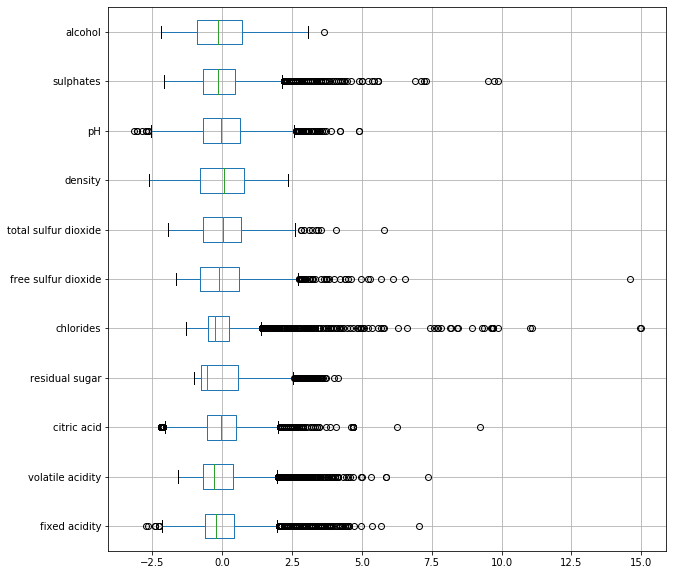

In [20]:
scaler = StandardScaler() # Normalizador de valores
numerics = df.drop(['type', 'quality'], axis=1)
  # Novo dataset apenas com colunas numéricas
numerics[numerics.columns] = scaler.fit_transform(numerics)
  # Normalização do novo dataset
numerics.boxplot(figsize=(10,10), vert=False) #Gráficos boxplot para cada coluna
plt.show()

In [21]:
numerics[numerics.chlorides > 9] # Outliers em chlorides

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4979,0.508822,0.515943,2.633161,-0.709130,11.014813,-0.450610,-0.833588,1.072417,-0.599170,5.027200,-0.984648
4981,0.104493,1.944232,-0.384591,-0.732592,9.312241,-0.788624,-1.118196,0.892863,-0.412007,4.087202,-0.984648
5004,0.508822,0.396919,2.495991,-0.756054,11.095888,-0.675953,-0.798012,1.036506,-0.911107,5.228629,-1.069229
5049,1.640945,1.051551,4.690719,-0.357200,14.960456,0.112748,-0.798012,1.862451,-3.032281,9.861477,-0.984648
5156,0.427956,0.396919,3.044673,-0.732592,14.987481,-1.239310,-1.224923,0.856953,-1.035882,4.892915,-0.984648
5349,0.994018,0.158871,1.467212,-0.732592,9.636540,-1.182974,-1.562895,1.251970,-1.035882,3.550060,-1.238390
5590,1.155749,0.873015,1.330041,-0.685668,9.879765,-0.788624,-0.922528,1.251970,-1.223045,4.288630,-1.322970
5652,0.508822,0.813503,2.495991,-0.756054,9.690590,-0.901296,-1.456167,0.770767,-0.848720,3.550060,-1.238390
5949,1.074883,0.694479,1.878723,-0.826440,9.663565,-0.788624,-1.224923,0.935956,-1.223045,5.430057,-1.153809
6158,1.155749,1.735940,2.495991,-0.732592,9.366291,-0.619617,-1.029256,0.684582,-1.285432,4.154345,-1.069229


In [22]:
numerics[numerics.sulphates > 9] # Outliers em chlorides

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4984,1.155749,0.873015,-0.247420,-0.709130,1.447979,-0.563281,0.393782,1.000595,-1.846919,9.525763,-0.561746
4990,1.155749,0.873015,-0.178835,-0.685668,1.447979,-0.619617,0.340418,1.000595,-1.846919,9.727191,-0.646326
5049,1.640945,1.051551,4.690719,-0.357200,14.960456,0.112748,-0.798012,1.862451,-3.032281,9.861477,-0.984648


In [23]:
numerics[numerics['citric acid'] > 9] # Outlier em free sulfur dioxide

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
745,0.185359,-0.852834,9.217347,-0.662206,-0.930217,0.225419,-0.015341,-0.992446,0.211867,0.125781,1.383607


In [24]:
numerics[numerics['free sulfur dioxide'] > 9] # Outlier em free sulfur dioxide

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4745,-0.865898,-0.495761,-0.453176,-0.47451,-0.254593,14.591032,5.801326,-0.457377,1.334842,0.730066,-0.054262


In [25]:
outliers = [745,4745,4984,4979,4981,4990,5004,5049,
            5156,5349,5590,5652,5949,6158,6217,6268] # Outliers identificados
df.drop(outliers, inplace=True) # Remoção dos outliers
print("{} Outliers removidos!". format(len(outliers)))

16 Outliers removidos!


De acordo com o site [r-statistics](https://www.r-statistics.com/), um _outlier_ é uma observação numericamente distante do restante dos dados. É possível identificá-los como bolinhas pretas no gráfico boxplot, localizados fora das cercas, "bigodes". [Saiba mais](https://www.r-statistics.com/2011/01/how-to-label-all-the-outliers-in-a-boxplot/).  
Devido a grande quantidade de outliers identificados, de acordo com a técnica boxplot, serão considerados apenas aqueles que estiverem acima de 9 variações. Estes pontos serão removidos para não impactarem negativamente no modelo.

In [26]:
df.info() # Informações após as trasnformações

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5171 entries, 0 to 6496
Data columns (total 13 columns):
type                    5171 non-null int8
fixed acidity           5171 non-null float64
volatile acidity        5171 non-null float64
citric acid             5171 non-null float64
residual sugar          5171 non-null float64
chlorides               5171 non-null float64
free sulfur dioxide     5171 non-null float64
total sulfur dioxide    5171 non-null float64
density                 5171 non-null float64
pH                      5171 non-null float64
sulphates               5171 non-null float64
alcohol                 5171 non-null float64
quality                 5171 non-null int64
dtypes: float64(11), int64(1), int8(1)
memory usage: 530.2 KB


Após várias transformações, o dataset final ficou com 5171 amostras e todos os 13 campos numéricos, sendo eles inteiros ou flutuantes.

### Análise Univariada

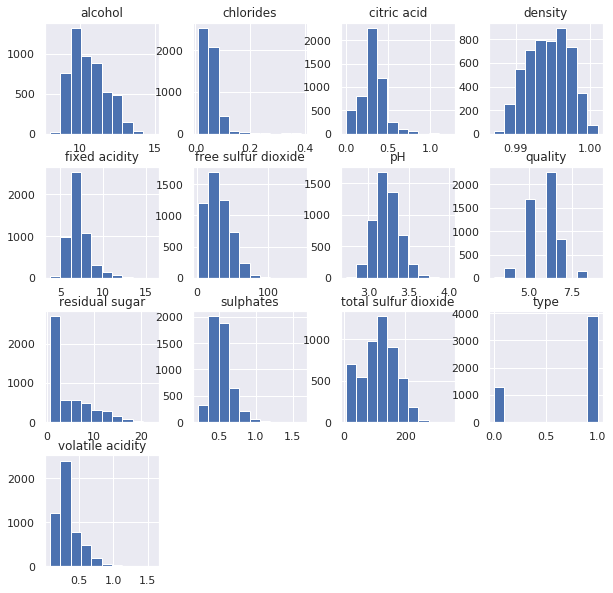

In [27]:
sns.set() # Setando estilo do seaborn para os gráficos
df.hist(figsize=(10,10)) # Gráficos de Histogramas para cada coluna
plt.show()

Acima vemos a distribuição de todas as colunas. Observamos que na coluna "type" a quantidade de amostras para o vinho branco é quase 4x maior em comparação com o vinho vermelho, mostrando o desbalanceamento entre as classes. As colunas "density", "alcohol" e "pH" estão bem distribuídas. Vemos [caudas longas](https://pt.m.wikipedia.org/wiki/Cauda_longa) nas colunas "chlorides" e "residual sugar". Em "quality" não conseguimos ver muito bem a distribuição para cada classe. Nos demais gráficos vemos as distribuições sendo empurradas para a esquerda por outliers.

In [28]:
df.quality.value_counts().sort_index() # contagem de amostras por qualidade

3      27
4     203
5    1688
6    2262
7     839
8     147
9       5
Name: quality, dtype: int64

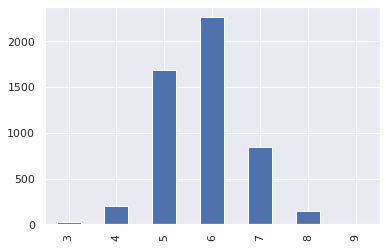

In [29]:
df.quality.value_counts().sort_index().plot.bar() # Gráfico de barras
plt.show()

Com o campo 'quality', foram contadas quantas amostras por categoria de qualidade. A maioria das amostras está entre os níveis 5, 6 e 7. Há poucas amostras para os demais níveis. Tendo isto em vista, espera-se que o modelo performe melhor para os níveis 5-7 e, devido a baixa quantidade de explares, pode não performar muito bem para os níveis 3-4 e 8-9

In [0]:
# Cógigo utilizado para auxiliar nas transformações de campos abaixo
# a = df.copy()
# df = a.copy()
# df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

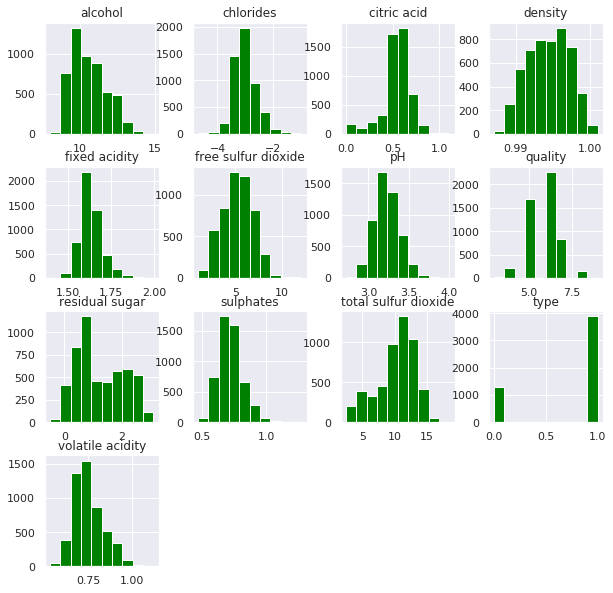

In [31]:
# Aplicação de função logarítmica
df.chlorides = df.chlorides.apply(np.log) 
df['residual sugar'] = df['residual sugar'].apply(np.log)

# Aplicação de função quadrática
df['citric acid'] = df['citric acid'].apply(np.sqrt)
df['fixed acidity'] = df['fixed acidity'].apply(np.sqrt)
df['free sulfur dioxide'] = df['free sulfur dioxide'].apply(np.sqrt)
df.sulphates = df.sulphates.apply(np.sqrt)
df['volatile acidity'] = df['volatile acidity'].apply(np.sqrt)
df['fixed acidity'] = df['fixed acidity'].apply(np.sqrt)
df['total sulfur dioxide'] = df['total sulfur dioxide'].apply(np.sqrt)
df['volatile acidity'] = df['volatile acidity'].apply(np.sqrt)

# Histogramas
df.hist(figsize=(10,10), color='green')
plt.show()

Para os campos que apresentaram aspecto de cauda longa aplicou-se função logarítmica e função quadrática para os demais, afim de melhorar a visualização e distribuição dos dados.

### Análise Bivariada

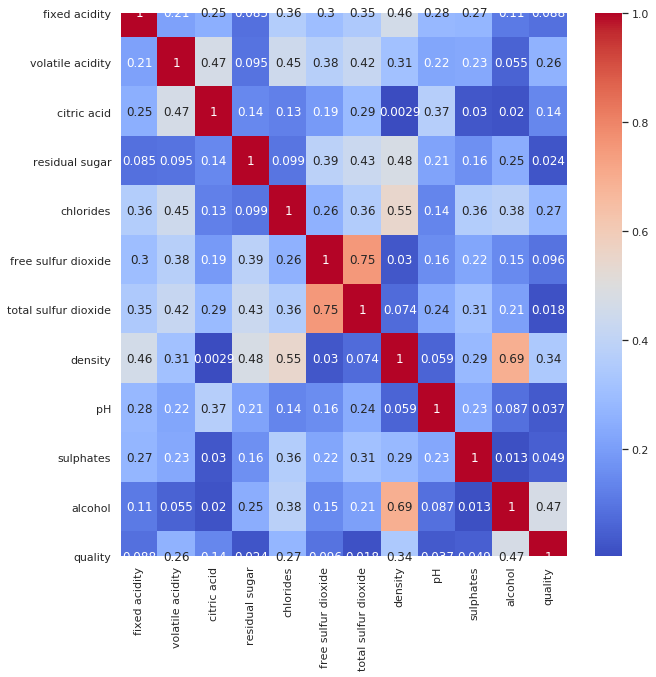

In [32]:
corr_matrix = df.drop('type', axis=1).corr().abs() # Matriz de correlação
plt.figure(figsize=(10,10)) # Dimensionamento da figura
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') # Mapa de calor + Matriz
plt.show()

Utilizamos uma matriz de correlação para auxiliar no estudo da influência de uma variável nas outras (correlação).  
Omitiu-se o campo "type" por se tratar de um categoria, ainda que seu tipo seja numérico. Nota-se correlações fracas (0.3-0.5), moderadas (0.5-0.7) e fortes (0.7-0.9). Entretanto não foram encontradas correlações muito fortes (0.9-1.0).
 [Saiba mais](https://pt.wikipedia.org/wiki/Coeficiente_de_correlação_de_Pearson).  
Vale ressaltar que, de acordo com a matriz, os campos que mais influenciam a qualidade do vinho são "alcohol", "density" e "chlorides".


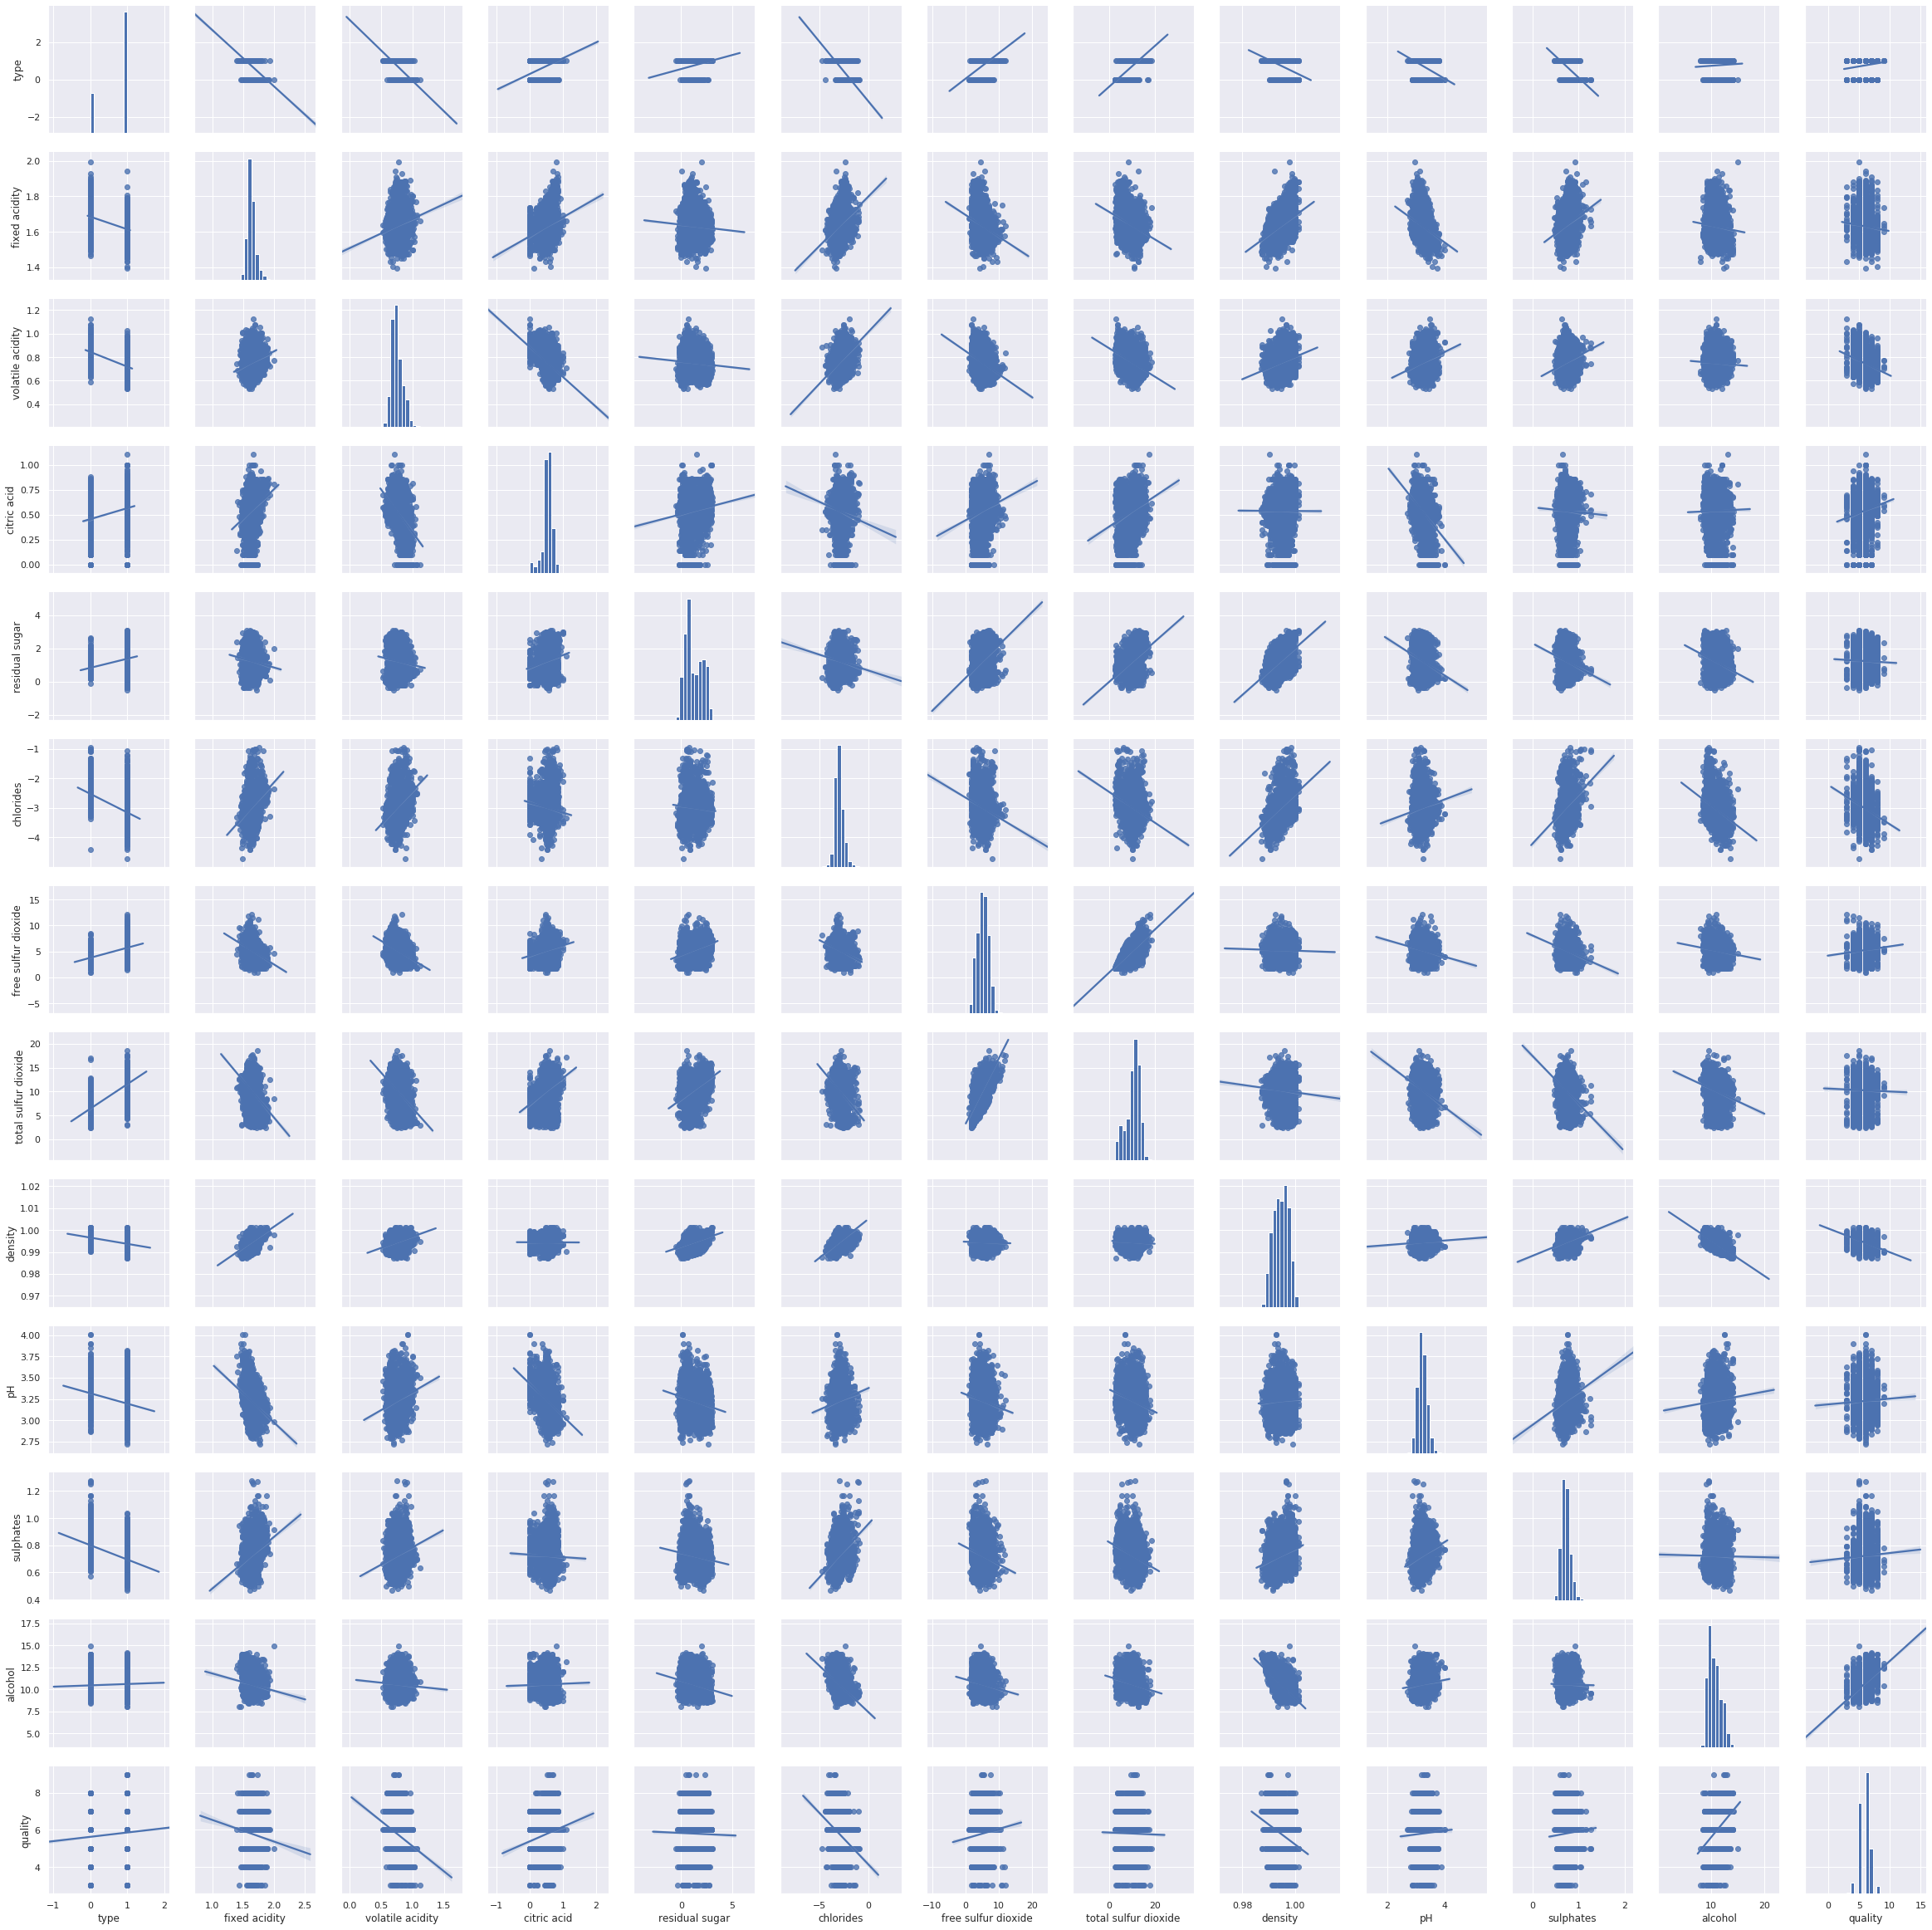

In [33]:
# correlations = ['type', 'volatile acidity', 'citric acid', 'pH', 'sulphates']
# sns.pairplot(df.drop(correlations, axis=1), kind="reg")
sns.pairplot(df, kind="reg") # Gráficos combinados
plt.show()

Acima temos um resumo dos histogramas e gráficos bivariados, onde é possível visualizar o sentido das correlações. Complementando a influência das variáveis na qualidade, "alcohol" influencia moderada e positivamente a qualidade do vinho, ou seja, quanto maior o teor alcoólico maior tende a ser a qualidade do vinho; em contra partida "density" e "chlorides" influenciam fraca e negativamente, o que nos leva a crer que vinhos com mais densidade ou mais sal tendem a perder em qualidade.

---

## Modelagem

In [0]:
seed = 0 # Semente aleatória
x = df.drop('quality', axis=1) # Variáveis de entrada
y = df.quality # Variáveis de saída

Na fase de modelagem, primeiro vamos definir uma semente aleatória para garantir reproducibilidade do processo. Na sequência, iremos separar as colunas em variáveis de entrada e variável de saída.

In [35]:
sel = SelectKBest(f_classif, k = 'all').fit(x, y) #Seletor de melhores variáveis
KBestTable(sel, x, x.columns) # Tabela de melhores variáveis

alcohol                 304.375080
density                 141.537230
chlorides                80.904321
volatile acidity         78.164984
free sulfur dioxide      19.047457
citric acid              18.333549
type                     15.191395
fixed acidity             7.993347
residual sugar            6.427303
total sulfur dioxide      6.382442
sulphates                 4.805110
pH                        2.876678
dtype: float64

Utilizou-se o módulo SelectKBest para ordenar as colunas por importância em relação a qualidade e, como esperado, as três mais importante são "alcohol", "density" e "chlorides". A métrica utilizada para isso foi a f_classif baseada na função F da ANOVA. [Saiba mais](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/).  
Também foi adicionado o módulo SelectKBest ao modelo, tornando-o uma sequência de passos (pipeline). Este módulo permite treinarmos o modelo com um número diferente de variáveis, já que uma maior quantidade de colunas não necessariamente melhora as previsões, podendo até confundi-lo em alguns casos.

In [36]:
# Modelos
clf1 = GaussianNB()
clf2 = DecisionTreeClassifier(random_state=seed)
clf3 = RandomForestClassifier(random_state=seed)
clf4 = MLPClassifier(random_state=seed)
clf5 = KNeighborsClassifier()
clf6 = SVC(random_state=seed)
clf7 = LogisticRegression()

# Parâmetros por modelo
prm1 = {}
prm2 = {'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm3 = {'clf__n_estimators':[10,50,100],'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm4 = {'clf__learning_rate_init':[0.001, 0.01], 'clf__max_iter':[200,500]}
prm5 = {'clf__n_neighbors': [3,5,10], 'clf__weights':['uniform', 'distance']}
prm6 = {'clf__C':[1,0.5], 'clf__shrinking':[False, True]}
prm7 = {'clf__solver':['sag'],'clf__multi_class':['multinomial'], 'clf__max_iter': [3,7]}

# Divisão Estratificada
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=seed)

#
summary = []
models = {}

#Looping para aplicar a função para todos os classificadores e parâmetros e armazenar os resultados no dicionário resultados
for clf, prm in [[clf1,prm1], [clf2,prm2],[clf3,prm3],[clf4,prm4],
                 [clf5,prm5],[clf6,prm6],[clf7,prm7]]:
  results, model = clfs_train_test(clf, prm, x_train, x_test, y_train, y_test)
  summary.append(results)
  models[results['nome']] = model

GaussianNB
--------------------

Tempo de treino: 0.3286120891571045
A melhor combinação de parâmetros:
{'sel__k': 6}
Maior F1-score: 0.47295358500266055
F1-score de Teste: 0.48488531813265123
Reporte de classificação:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.17      0.10      0.13        41
           5       0.55      0.64      0.59       338
           6       0.53      0.47      0.50       453
           7       0.38      0.46      0.42       168
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00         1

    accuracy                           0.50      1035
   macro avg       0.23      0.24      0.23      1035
weighted avg       0.48      0.50      0.48      1035




DecisionTreeClassifier
--------------------

Tempo de treino: 3.4856069087982178
A melhor combinação de parâmetros:
{'clf__max_depth': 5, 'clf__min_samples_leaf': 50, 'sel__k': 9}
M

Definiu-se o problema como classificação. Já que não há opções de valores entre as classes, não podemos classificar um vinho como 5,5 por exemplo.  
Para o modelo, foram testados GaussianNB, DecisionTree, RandomForest, MLP, KNN, SVC e LogisticRegression. Cada um com algumas opções de parâmetros. Todas as divisões de dataset foram feitas de modo estratificado, ou seja, toda divisão utiliza uma proporção de cada nível de qualidade para que todos os treinos e testes sejam realizados com todas as classes.


In [37]:
ordenado = ['nome', 'best_score', 'score_treino', 'tempo_treino']
pd.DataFrame(summary, columns=ordenado)\
  .sort_values('score_treino', ascending=False)

,nome,best_score,score_treino,tempo_treino
3,MLPClassifier,0.507860,0.533479,120.313972
2,RandomForestClassifier,0.540229,0.518059,114.521614
5,SVC,0.489538,0.494123,58.264387
4,KNeighborsClassifier,0.503950,0.487347,3.361094
0,GaussianNB,0.472954,0.484885,0.328612
6,LogisticRegression,0.445525,0.470641,0.892695
1,DecisionTreeClassifier,0.506295,0.469890,3.485607


Acima temos uma tabela que sumariza os resultados. O modelo MLP teve o melhor resultado seguido pelo RandomForest. Coincidentemente, ambos os modelos tiveram os maiores tempos de treinamento. Devido a baixa diferença entre eles, definiu-se MLP (com os parâmetros indicados) como o melhor modelo dentre os testados, ainda que RandomForest tenha se saído melhor na etapa de treino.

---

## Conclusão

1. **Quais variáveis impactam na qualidade do vinho?**  
De acordo com a matriz de correlação, os gráficos bivariados e o módulo SelectKBest, as variáveis que mais impactam na qualidade do vinho são: alcohol, density e chlorides.
1. **Como foi a definição da sua estratégia de modelagem?**  
Para modelagem, definiu-se um processo de duas etapas: seleção de variáveis (SelectKBest) e modelo de ML.
Para a segunda etapa, foram testados 7 modelos de ML com diferentes opções de parâmetros. Utilizou-se técnicas de hiper-parametrização e validação cruzada para definir o melhor modelo, com a melhor combinação de parâmetros e número de variáveis, de modo a maximizar a métrica F-1.
1. **Como foi definida a função de custo utilizada?**  
A função de custo utilizada foi a métrica F-1, pois considerou-se importante não somente a quantidade de acertos do modelo, mas também que ele seja capaz de identificar bem cada um dos níveis de qualidade. Sendo a métrica citada uma média harmônica entre precisão e sensibilidade, que oferece um ótimo balanceamento e, consequentemente, uma boa métrica para este fim.
1. **Qual foi o critério utilizado na seleção do modelo final?**  
Separou-se um conjunto de dados de teste para simular um ambiente com dados desconhecidos. Ainda que o RandomForest tenha apresentado melhor pontuação para os dados de treino, escolheu-se MLP como modelo final por este ter se saído melhor com os dados de teste, sem que o tempo de treinamento tenha apresentado diferença significativa em relação ao outro modelo.
1. **Qual foi o critério utilizado para validação do modelo? Por que escolheu utilizar este método?**  
Para validação do modelo, utilizou-se duas técnicas: validação cruzada e divisão estratificada. Devido ao baixo número de amostras dos níveis de qualidade 3, 4, 8 e 9 em relação aos demais, torna-se importante um processo que, mesmo aleatório, consiga selecionar ao menos uma amostra de cada classe tanto para treino quanto para teste. Deste modo, evita-se a obtenção de altas pontuações por acaso da divisão selecionar apenas amostras com as qualidade que o modelo esteja performando muito bem. Em adição, os modelos foram testados com uma amostra estratificada omitida na etapa de treinamento, simulando assim um caso real com dados novos.
1. **Quais evidências você possui de que seu modelo é suficientemente bom?**  
Ainda que os dados e modelos tenham passado por todos esses diversos processos, não se considera que o modelo final seja suficientemente bom. Sendo assim, restam as sugestões abaixo:
  + Obter mais dados das classes 3,4,8 e 9;
  + Criar modelos diferentes para vinhos tintos e vinhos brancos;
  + Testar modelos mais complexos como xgboost, redes neurais mais profundas e modelos combinados;
  + Testar mais parâmetros;
  + Realizar mais engenharia de feature para criação/transformação/combinação de possíveis variáveis com mais impacto na qualidade do vinho.

---

## Referências

+ <https://github.com/MwillianM/EronFraudIdentification>
+ <http://google.github.io/styleguide/pyguide.html>
+ <http://www.uvibra.com.br/legislacao_portaria229.htm>
+ <https://unsplash.com/>
+ <https://blog.famigliavalduga.com.br/afinal-o-que-e-vinho-verde/>
+ <https://drive.google.com/open?id=1-oG5-kBt9xQ3Li4PEexpiA9_7RZhRM1f>
+ <https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt>
+ <https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/>

---

## Extras

In [0]:
# pandas-profiling não utilizado para uma melhor descrição e guia das análises

# !pip install -U pandas-profiling
# import pandas_profiling
# profile = df.profile_report()
# df.profile_report(style={'full_width':True})

In [0]:
#Abordagem com deep learning não utilizada devido a baixa quantidade de amostras

# !pip install -U tensorflow

# import tensorflow as tf
# print(tf.__version__)

# from sklearn.model_selection import train_test_split 
# label = 'quality'
# X = df.drop([label, 'type'], axis=1)
# # X.type[X.type == 'White'] = 1
# # X.type[X.type == 'Red'] = 0
# y = encoder.fit_transform(df[[label]])
# X_train, X_test, y_train, y_test = train_test_split( 
#            X, y, test_size = 0.2, random_state = 42) 

# import tensorflow as tf
# from tensorflow import keras

# model = keras.Sequential([
#     keras.layers.Dense(11, activation ='relu', input_shape =(11, )),
#     keras.layers.Dense(9, activation ='relu'),
#     keras.layers.Dense(7, activation ='sigmoid')
# ])

# model.output_shape 
# model.summary() 
# model.get_config() 
  
# # List all weight tensors 
# model.get_weights() 
# model.compile(loss ='sparse_categorical_crossentropy',  
#   optimizer ='adam', metrics =['accuracy']) 

# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# transfomed_label = encoder.fit_transform(y)
# transfomed_label

# model.fit(X_train, y_train, epochs = 3, 
#            batch_size = 1, verbose = 1) 
   
# # Predicting the Value 
# y_pred = model.predict(X_test) 
# print(y_pred)

---